# How to load the natural images used in the Monkey Experiment and creating saliency maps

notebook loads images from folder, creates saliency maps by them and stores this saliency maps in a folder. 

dsrex3 version of DeepGaze is used

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.misc import face
import torch
import torchvision
import torchvision.transforms as transforms
import gc

In [2]:
img_path = "/data/monkey/toliaslab/CSRF19_V4/images/"
images = [np.load(img_path + i) for i in os.listdir(img_path) if ".npy" in i ]


[[255 255 255 ... 232 238 242]
 [255 255 255 ... 241 241 240]
 [255 255 255 ... 241 240 239]
 ...
 [210 210 213 ... 208 209 208]
 [213 214 211 ... 207 206 206]
 [211 217 209 ... 207 208 207]]


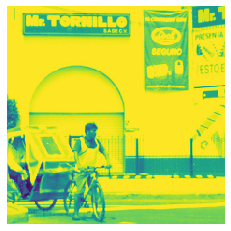

In [38]:
# example image
plt.imshow(images[0])
plt.axis("off");
print(images[0])

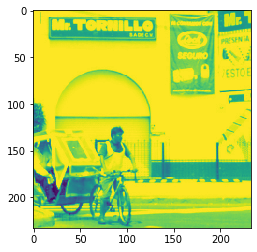

In [75]:
#cropping:
image = images[0]
crop = [(0, 0), (0, 0)]
h, w = image.shape
image = image[crop[0][0]:h - crop[0][1]:1,
                    crop[1][0]:w - crop[1][1]:1]

plt.imshow(image)


In [41]:

from deepgaze_pytorch import load_pytorch_model_from_experiment

from deepgaze_pytorch.deepgaze2_dsrex3 import deepgaze2_dsrex3
dsrex3 = deepgaze2_dsrex3(pretrained=False).to('cuda')
dsrex3.load_state_dict(torch.load('/notebooks/Katharina/DeepGazeII_DSREx3.pth'))

In [42]:
gc.collect()
torch.cuda.empty_cache()

deepgaze_2 = load_pytorch_model_from_experiment(
    experiment_directory='/var/sinz-shared/image_saliency/experiment0051_DeepGazeII_average_image',
    training_part='MIT1003',
    crossval_fold=0,
)

Targets are ['conv5_1', 'relu5_1', 'relu5_2', 'conv5_3', 'relu5_4']
Remaining training parameters
saliency_network.layernorm0.weight
saliency_network.layernorm0.bias
saliency_network.conv0.weight
saliency_network.bias0.bias
saliency_network.layernorm1.weight
saliency_network.layernorm1.bias
saliency_network.conv1.weight
saliency_network.bias1.bias
saliency_network.layernorm2.weight
saliency_network.layernorm2.bias
saliency_network.conv2.weight
saliency_network.bias2.bias
scanpath_network.layernorm0.weight
scanpath_network.layernorm0.bias
scanpath_network.conv0.weight
scanpath_network.bias0.bias
scanpath_network.layernorm1.weight
scanpath_network.layernorm1.bias
scanpath_network.conv1.weight
scanpath_network.bias1.bias
fixation_selection_network.layernorm0.layernorm_part0.weight
fixation_selection_network.layernorm0.layernorm_part0.bias
fixation_selection_network.layernorm0.layernorm_part1.weight
fixation_selection_network.layernorm0.layernorm_part1.bias
fixation_selection_network.conv0

In [77]:
gc.collect()
torch.cuda.empty_cache()

image = images[0]
centerbias = np.zeros(image.shape)
image = np.repeat(image[:, :, np.newaxis], 3, axis=2)

log_density = dsrex3.forward(
    x=torch.tensor([image.transpose(2, 0, 1)], dtype=torch.float32).to('cuda'),
    centerbias=torch.tensor([centerbias]).to('cuda')
    ,x_hist=torch.tensor([[400, 800]]).to('cuda'),
    y_hist=torch.tensor([[500, 600]]).to('cuda'),
).detach().cpu().numpy()[0]

print(log_density.shape)

[[-11.25555973 -11.25555973 -11.25555973 ... -15.6704927  -15.6704927
  -15.6704927 ]
 [-11.25555973 -11.25555973 -11.25555973 ... -15.6704927  -15.6704927
  -15.6704927 ]
 [-11.25555973 -11.25555973 -11.25555973 ... -15.6704927  -15.6704927
  -15.6704927 ]
 ...
 [-13.64606344 -13.64606344 -13.64606344 ... -13.66866376 -13.66866376
  -13.66866376]
 [-13.64606344 -13.64606344 -13.64606344 ... -13.66866376 -13.66866376
  -13.66866376]
 [-13.64606344 -13.64606344 -13.64606344 ... -13.66866376 -13.66866376
  -13.66866376]]


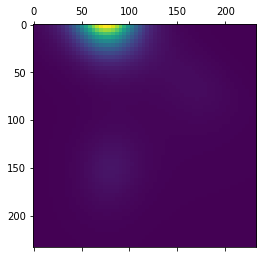

In [78]:
plt.matshow(np.exp(log_density))



In [9]:
img_stack = np.stack(images)

In [10]:
# these are all the 24075 images that we use in our monkey experiments
print(img_stack.shape)
import datetime

(24075, 233, 233)


In [11]:
img_path1 = ("/data/monkey/toliaslab/CSRF19_V4/images_saliency_scaled")
img_path2 = ("/data/monkey/toliaslab/CSRF19_V4/images")

list_for_saving = []
[list_for_saving.append(i) for i in os.listdir(img_path2) if ".npy" in i]
print("List done")

List done


In [65]:
#cropping
def cropping(image, size):
    crop = size
    h, w = image.shape
    image = image[crop[0][0]:h - crop[0][1]:1,
                    crop[1][0]:w - crop[1][1]:1]
    return image




In [ ]:
## rescales images with the PIL package
## then creates two copies and stacks them toghether, so that we have three channels as if we would have a color image

from PIL import Image
im_array = []
for i in images:

    image = Image.fromarray(i, mode=None)

    image = image.resize((1067, 600))
    image = np.asarray(image)

    image = np.repeat(image[:, :, np.newaxis], 3, axis=2)

    im_array.append(image)

#img_stack2 = np.stack(im_array)

In [87]:
#img_stack = np.stack(images)


centerbias = np.zeros((600, 1067))   #has to be other way round than in resize



def save_images(images):
    for k in range(0, len(images)-1):
        image = images[k]
        #image = Image.fromarray(image)
        #image = image.resize((1067, 600))
        #image =np.asarray(image)
        image = cv2.resize(image, dsize=(1067, 600), interpolation=cv2.INTER_CUBIC)

        image = np.repeat(image[:,:,np.newaxis], 3, axis=2)


        log_dens = dsrex3.forward(
            x=torch.tensor([image.transpose(2, 0, 1)], dtype=torch.float32).to('cuda'),
            centerbias=torch.tensor([centerbias]).to('cuda')).clone().detach().cpu()[0].numpy()

        log_dens = np.reshape(log_dens, (600, 1067))
        log_dens = cv2.resize(log_dens, dsize=(420, 236), interpolation=cv2.INTER_CUBIC)

        np.save(str("/data/monkey/toliaslab/CSRF19_V4/images_saliency_scaled/" + list_for_saving[k]), log_dens)




save_images(images)



20


In [ ]:
#img_stack = np.stack(images)

img_stack = np.stack(images)
centerbias = np.zeros((600, 1067))
k = 0


def save_images(item):
    print(item.shape)
    image = cv2.resize(item, dsize=(600, 1067), interpolation=cv2.INTER_CUBIC)
    image = np.repeat(item[:,:,np.newaxis], 3, axis=2)
    log_dens = dsrex3.forward(
        x=torch.tensor([image.transpose(2, 0, 1)], dtype=torch.float32).to('cuda'),
        centerbias=torch.tensor([centerbias]).to('cuda')).clone().detach().cpu()[0].numpy()
    log_dens = cv2.resize(item, dsize=(236, 420), interpolation=cv2.INTER_CUBIC)
    return log_dens


log_dens_array = np.stack(np.vectorize(save_images, otypes=[np.ndarray])(images))

print('Done')


for log_dens in log_dens_array:
    #log_dens = save_images(image)

    np.save(str("/data/monkey/toliaslab/CSRF19_V4/images_saliency_scaled/" + list_for_saving[k]), log_dens)
    k+= 1

print("Done")

0 1 0
0 3 1
0 5 2
1 1 3
1 3 4
1 5 5
2 1 6
2 3 7
2 5 8
3 1 9
3 3 10
3 5 11
4 1 12
4 3 13
4 5 14
5 1 15
5 3 16
5 5 17


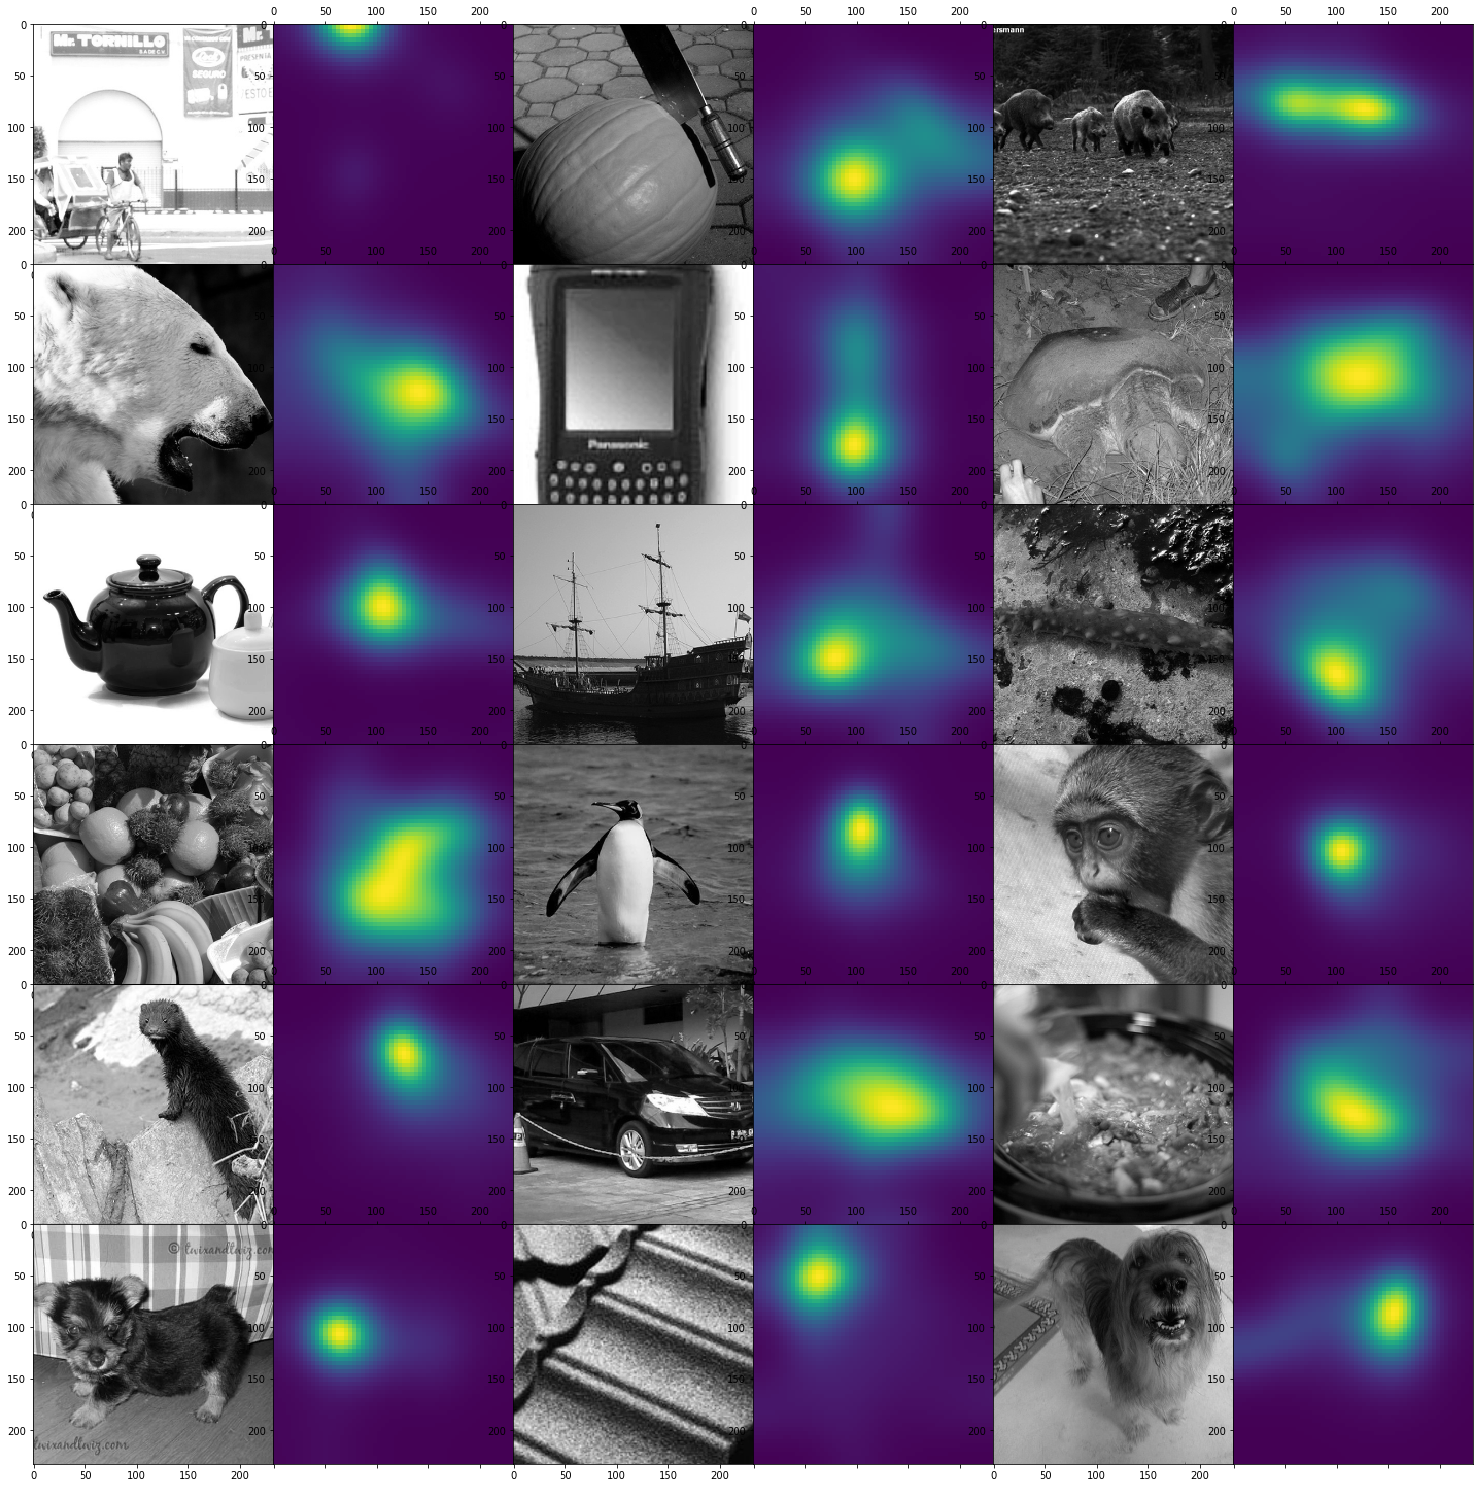

In [88]:
# here, you could add the saliency map next to each picture

fig, axs = plt.subplots(6, 6, figsize=(20,20))

j= 0
k = 0
crop = [(0, 0), (0, 0)]
for i in range(0, 6):
    for count in range(0,3):
        image = cropping(images[k], crop)
        axs[i][j].imshow(image, cmap="gray")
        j += 1
        print(i, j, k)
        axs[i][j].matshow(np.exp(log_dens_array[k]))
        j+= 1
        if (j>5):
            j = 0
        k += 1
fig.tight_layout()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    #axs.axis("off")

In [ ]:
# here, you could add the saliency map next to each picture

fig, axs = plt.subplots(5,5, figsize=(20,20))


img_stack = np.stack(images[0:51])
sal_stack = np.stack(log_dens_array)


both_images = np.concatenate((img_stack, sal_stack), axis=0)
for i, ax in enumerate(axs.ravel()):
    ax.imshow(both_images[i])
